In [1]:
import torch
from torch_geometric.data  import Data
import rdkit
from rdkit.Chem import MolFromSmiles, Draw
import networkx as nx
from torch_geometric.datasets import MoleculeNet
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import to_networkx
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

/opt/homebrew/Caskroom/miniforge/base/envs/pyg_env/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
! [ -e outputs ] || mkdir outputs
OUPTUT_DIR_PATH = 'outputs'

to_output = lambda file_path : os.path.join(OUPTUT_DIR_PATH,file_path)


In [5]:
molecule_net = MoleculeNet(root='.',name='HIV')
graph_number = len(molecule_net)
print(f'There are {graph_number} graphs in the dataset')


Processing...


There are 41127 graphs in the dataset


Done!


In [11]:
first_graph = molecule_net.get(0)
n_nodes = first_graph.num_nodes
n_edges = first_graph.num_edges
n_features = first_graph.num_features
adj_matrix = to_dense_adj(first_graph.edge_index)
print(f"{n_nodes = }")
print(f"{n_edges = }")
print(f"{n_features = }")
print(f"{adj_matrix = }")
first_graph

n_nodes = 19
n_edges = 40
n_features = 9
adj_matrix = tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 1.],
         [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

Data(x=[19, 9], edge_index=[2, 40], edge_attr=[40, 3], smiles='CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2', y=[1, 1])

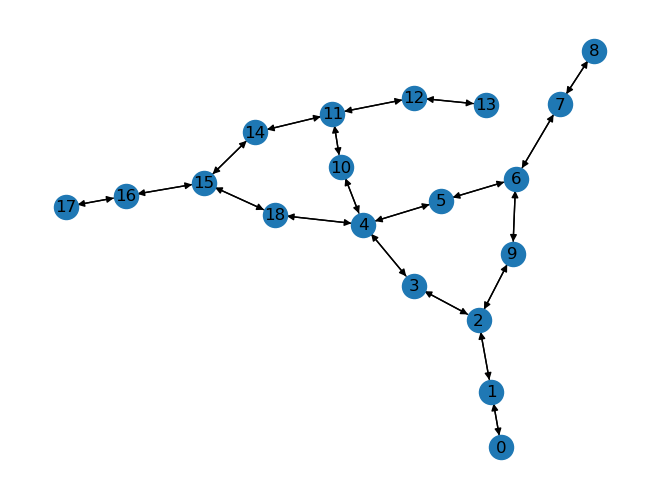

In [9]:
nx.draw(to_networkx(first_graph), with_labels=True)

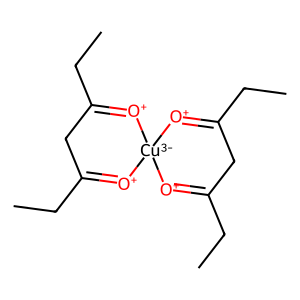

In [10]:
smiles = first_graph['smiles']
Draw.MolToImage(MolFromSmiles(smiles))

In [21]:
x_map = {
    'atomic_num':
    list(range(0, 119)),
    'chirality': [
        'CHI_UNSPECIFIED',
        'CHI_TETRAHEDRAL_CW',
        'CHI_TETRAHEDRAL_CCW',
        'CHI_OTHER',
    ],
    'degree':
    list(range(0, 11)),
    'formal_charge':
    list(range(-5, 7)),
    'num_hs':
    list(range(0, 9)),
    'num_radical_electrons':
    list(range(0, 5)),
    'hybridization': [
        'UNSPECIFIED',
        'S',
        'SP',
        'SP2',
        'SP3',
        'SP3D',
        'SP3D2',
        'OTHER',
    ],
    'is_aromatic': [False, True],
    'is_in_ring': [False, True],
}




e_map = {
    'bond_type': [
        'misc',
        'SINGLE',
        'DOUBLE',
        'TRIPLE',
        'AROMATIC',
    ],
    'stereo': [
        'STEREONONE',
        'STEREOZ',
        'STEREOE',
        'STEREOCIS',
        'STEREOTRANS',
        'STEREOANY',
    ],
    'is_conjugated': [False, True],
}

In [22]:
x_map.keys()

dict_keys(['atomic_num', 'chirality', 'degree', 'formal_charge', 'num_hs', 'num_radical_electrons', 'hybridization', 'is_aromatic', 'is_in_ring'])

In [23]:
def mol2graph(mol, y, smiles):

    
    xs = []

    for atom in mol.GetAtoms():

        x = []

        x.append(x_map['atomic_num'].index(atom.GetAtomicNum()))
        # The atomic number is the number of protons in the nucleus of an atom

        x.append(x_map['chirality'].index(str(atom.GetChiralTag())))

        x.append(x_map['degree'].index(atom.GetTotalDegree()))
        # the number of carbon atoms that this atom is attached to

        x.append(x_map['formal_charge'].index(atom.GetFormalCharge()))
        x.append(x_map['num_hs'].index(atom.GetTotalNumHs()))
        x.append(x_map['num_radical_electrons'].index(
            atom.GetNumRadicalElectrons()))
        x.append(x_map['hybridization'].index(str(atom.GetHybridization())))
        x.append(x_map['is_aromatic'].index(atom.GetIsAromatic()))
        x.append(x_map['is_in_ring'].index(atom.IsInRing()))

        xs.append(x)



    x = torch.tensor(xs, dtype=torch.float).view(-1, 9)

    #print("x", x)

    edge_indices, edge_attrs = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        e = []
        e.append(e_map['bond_type'].index(str(bond.GetBondType())))
        e.append(e_map['stereo'].index(str(bond.GetStereo())))
        e.append(e_map['is_conjugated'].index(bond.GetIsConjugated()))

        edge_indices += [[i, j], [j, i]]
        edge_attrs += [e, e]

    edge_index = torch.tensor(edge_indices)
    edge_index = edge_index.t().to(torch.long).view(2, -1)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.long).view(-1, 3)

    # Sort indices.
    y = torch.tensor(y, dtype=torch.long)

    if edge_index.numel() > 0:
        perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
        edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y = y, smiles=smiles)

    return data

In [24]:
smiles_acetic_acid = "CC(O)=O"
mol = MolFromSmiles(smiles_acetic_acid)
y = 1
acetic_acid_graph = mol2graph(mol, y, smiles_acetic_acid)
acetic_acid_graph

Data(x=[4, 9], edge_index=[2, 6], edge_attr=[6, 3], y=1, smiles='CC(O)=O')

In [26]:
acetic_acid_graph.x, acetic_acid_graph.edge_index, acetic_acid_graph.edge_attr

(tensor([[6., 0., 4., 5., 3., 0., 4., 0., 0.],
         [6., 0., 3., 5., 0., 0., 3., 0., 0.],
         [8., 0., 2., 5., 1., 0., 3., 0., 0.],
         [8., 0., 1., 5., 0., 0., 3., 0., 0.]]),
 tensor([[0, 1, 1, 1, 2, 3],
         [1, 0, 2, 3, 1, 1]]),
 tensor([[1, 0, 0],
         [1, 0, 0],
         [1, 0, 1],
         [2, 0, 1],
         [1, 0, 1],
         [2, 0, 1]]))

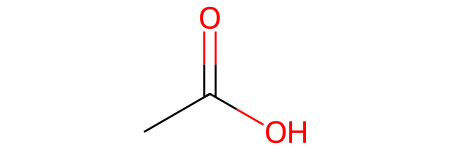

In [27]:
mol

In [28]:
n_features = acetic_acid_graph.num_features
print(f'{n_features = }')
acetic_acid_graph

n_features = 9


Data(x=[4, 9], edge_index=[2, 6], edge_attr=[6, 3], y=1, smiles='CC(O)=O')

In [29]:
active_data_path = os.path.join('hiv', 'active_data.csv')
active_df = pd.read_csv(active_data_path)
active_df.head()


,SMILES,ID,is_active
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,1
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,1
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,1
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,1
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,1


In [30]:
n_active_mol = len(active_df[active_df['is_active'] == 1])
n_decoys_mol = len(active_df[active_df['is_active'] == 0])
print(f'{n_active_mol = } active molecules')
print(f'{n_decoys_mol = } decoys')
print(f'{len(active_df) = } total molecules')

n_active_mol = 79 active molecules
n_decoys_mol = 300 decoys
len(active_df) = 379 total molecules


In [31]:
molecules = list(map(MolFromSmiles, active_df['SMILES']))

In [35]:
process_func = lambda active_data:mol2graph(MolFromSmiles(active_data['SMILES']), active_data['is_active'], active_data['SMILES'])
list_data = list(map(process_func, active_df.iloc))

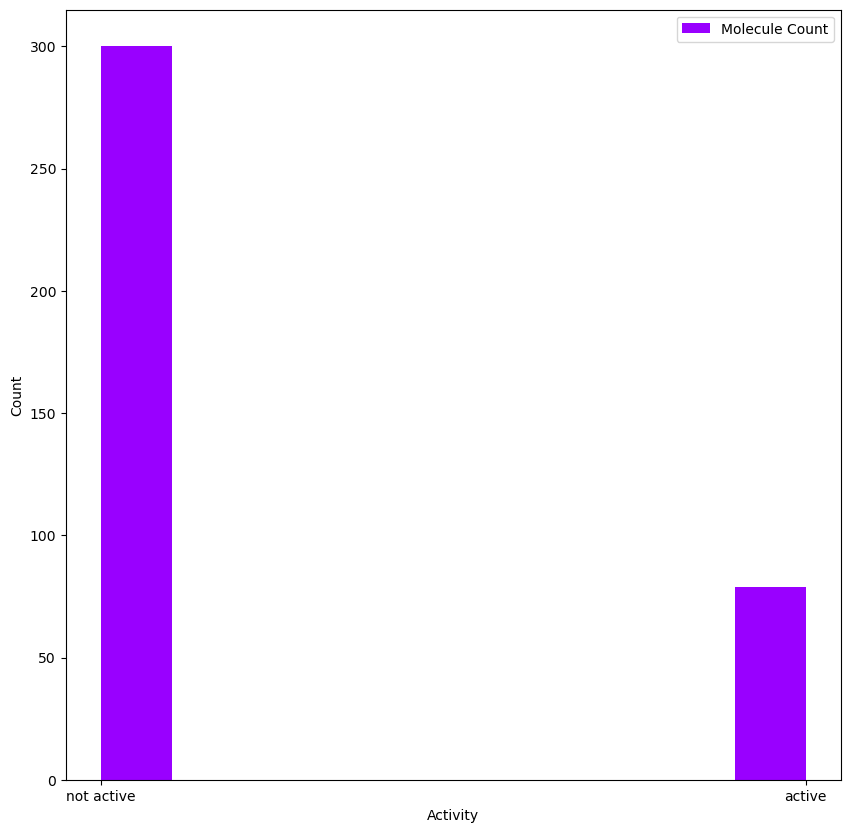

In [40]:
fig = plt.figure(figsize=(10, 10))
ax= fig.add_subplot(111)
counts, bins = np.histogram(active_df['is_active'], bins=2)
ax.set_xlabel('Activity')
ax.set_ylabel('Count')
uniques_val , counts = np.unique(active_df['is_active'], return_counts=True)
ax.hist(['not active', 'active'],weights=counts, label='Molecule Count', color=(0.6, 0, 1))
ax.legend()
plt.show()
fig.savefig('activity_plot.png')

In [42]:
random.seed(123)
random.shuffle(list_data)
train_data = list_data[:int(len(list_data)*0.75)]
test_data = list_data[int(len(list_data)*0.75):]
len(train_data), len(test_data)

(284, 95)

In [45]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
batch = next(iter(train_loader))
print(f'{len(batch) } grapgs in this batch')
batch

32 grapgs in this batch


/opt/homebrew/Caskroom/miniforge/base/envs/pyg_env/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


DataBatch(x=[768, 9], edge_index=[2, 1668], edge_attr=[1668, 3], y=[32], smiles=[32], batch=[768], ptr=[33])

In [46]:
gnn = GCNConv(acetic_acid_graph.num_node_features, 16)
output = gnn(acetic_acid_graph.x, acetic_acid_graph.edge_index)
output

tensor([[-0.9945,  1.9765, -3.5673,  3.0867, -0.5313, -2.8364,  1.1229, -3.2820,
         -2.3087, -0.4845,  0.7136,  1.4958, -3.1962, -1.9572, -2.9587,  1.6940],
        [-0.9307,  3.6971, -6.0775,  5.3097, -0.4079, -3.5850,  2.1565, -4.9684,
         -3.0316, -0.3133,  0.8091,  2.9320, -4.7078, -2.8442, -4.1072,  2.2794],
        [-0.6579,  2.2553, -4.2461,  3.2792, -0.2504, -2.1190,  1.4126, -3.1823,
         -1.8963, -0.1010,  0.4312,  1.9549, -2.9976, -1.7125, -2.6084,  1.4912],
        [-0.4709,  2.2598, -4.2733,  3.3589, -0.1192, -1.7482,  1.3976, -2.8284,
         -1.5693, -0.0213,  0.3155,  2.0082, -2.6045, -1.4502, -2.4682,  1.2350]],
       grad_fn=<AddBackward0>)

In [48]:
print(f'{output.size()}'), acetic_acid_graph


torch.Size([4, 16])


(None,
 Data(x=[4, 9], edge_index=[2, 6], edge_attr=[6, 3], y=1, smiles='CC(O)=O'))

In [49]:
data_test_GMP_layer = DataLoader([acetic_acid_graph], batch_size=1, shuffle=False)
conv_test = GCNConv(9, 16)
data = next(iter(data_test_GMP_layer))
out_GCN_layer = conv_test(data.x, data.edge_index)
out_GMP_layer = global_mean_pool(out_GCN_layer, data.batch)
print(f'{out_GMP_layer.size()}')

torch.Size([1, 16])


/opt/homebrew/Caskroom/miniforge/base/envs/pyg_env/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [50]:
from torch_geometric.nn import GCNConv, global_mean_pool

from torch import nn
import torch
import torch.nn.functional as F
from torch.nn import Linear

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        torch.manual_seed(12)
        self.conv1 = GCNConv(9, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.lin = Linear(64, 2)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        x =self.lin(x)
        return x    

In [51]:
model = Net()
# print number of parameters
print(sum(p.numel() for p in model.parameters()))

2946


In [53]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

print(model)


Net(
  (conv1): GCNConv(9, 16)
  (conv2): GCNConv(16, 32)
  (conv3): GCNConv(32, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [58]:
def train(loader, model, optimizer, loss_func):
    model.train()
    for data in loader:
        # 1. Forward pass
        out = model(data.x, data.edge_index, data.batch)
        
        # 2. Compute the loss
        loss = loss_func(out, data.y)
        
        # 3. Calculate the gradient
        loss.backward()
        
        # 4. Update the parameters (weights)
        optimizer.step()
        
        # 5. Clean gradients
        optimizer.zero_grad()

In [59]:
def test(loader,model):
    model.eval()
    correct = 0
    for data in loader:
        # output of the model
        out =  model(data.x,data.edge_index,data.batch)
        # Use the class with highest probability
        pred = out.argmax(dim=1)
        

        # Check against ground-truth labels
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

In [60]:
from tqdm import tqdm
epochs = 100
model = Net()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_func = nn.CrossEntropyLoss()
print(model)
train_accs = []
test_accs = []
for epoch in (range(1,epochs+1)):
    train(train_loader,model,optimizer,loss_func)
    train_acc = test(train_loader,model)
    test_acc =test(test_loader,model)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    
    # print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
history_df = pd.DataFrame({'train_accuracy':train_accs,'test_accuracy':test_accs})
history_df.to_csv(to_output('history.csv'))

Net(
  (conv1): GCNConv(9, 16)
  (conv2): GCNConv(16, 32)
  (conv3): GCNConv(32, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [61]:
test(test_loader,model)


0.8315789473684211

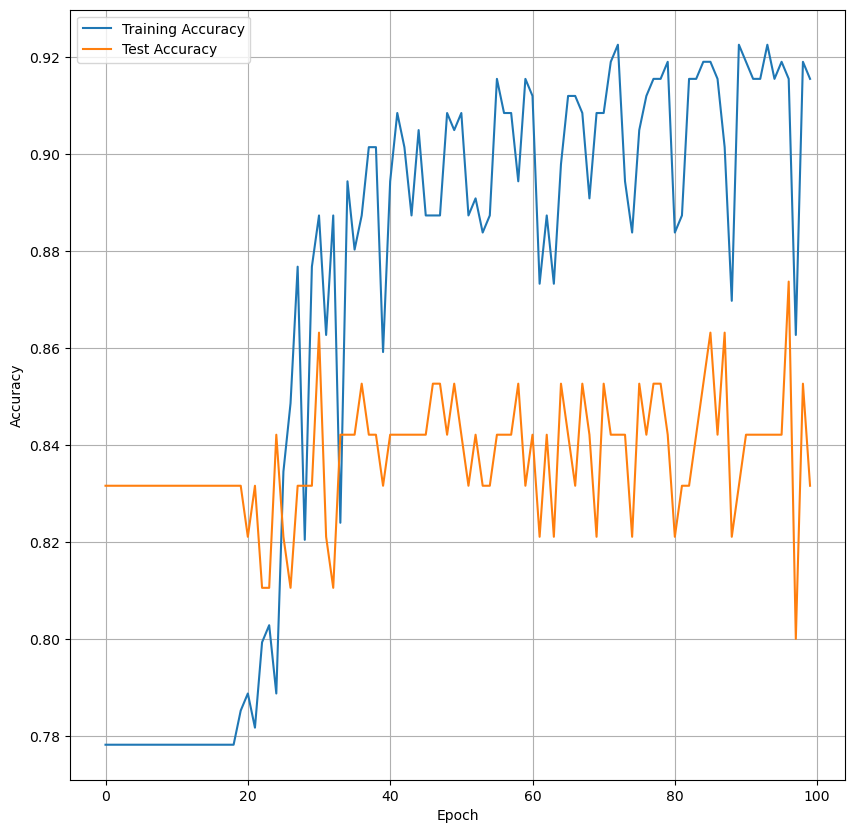

In [63]:
fig = plt.figure(figsize=(10, 10))
ax= fig.add_subplot(111)
ax.plot(history_df['train_accuracy'], label='Training Accuracy')
ax.plot(history_df['test_accuracy'], label='Test Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True)
plt.show()
fig.savefig('accuracy_plot.png')    